## Protein & DNA enrichment statistics for deletions and substitutions in GFP
### eGFP & GFP8; 4 libraries: -3 bp, -6 bp, -9 bp, 3 bp sub; starting library + sorted into 3 fractions each

The analysis functions are located in `../indels/proteins.py`, which draws general functions from `../indels/ind.py`

### Previous processing of the libraries

Reference sequences:

`>eGFP
atgagtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactctgacgtatggtgttcaatgcttttcccgttatccggatcacatgaaacggcatgactttttcaagagtgccatgcccgaaggttatgtacaggaacgcactatattcttcaaagatgacgggaactacaagacgcgtgccgaggtcaagtttgaaggtgatacccttgttaatcgtatcgagttaaaaggtattgattttaaagaagatggaaacattctcggacacaaactcgagtacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattcgccacaacattgaagatggatccgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtcgacacaatctgccctttcgaaagatcccaacgaaaagcgtgaccacatggtccttcttgagtttgtaactgctgctgggattacacatggcatggatgagctctacaaaaAGCTT`

`>GFP8
atgagtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtccgtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactctgacgtatggtgttcaatgcttttcccgttatccggatcacatgaaacggcatgactttttcaagagtgccatgcccgaaggttatgtacaggaacgcactatatccttcaaagatgacgggacctacaagacgcgtgccgaggtcaagtttgaaggtgatacccttgttaatcgtatcgagttaaaaggtattgattttaaagaagatggaaacattctcggacacaaactcgagtacaactataactcacacaatgtatacatcacggcagacaaacaaaagaatggaatcaaagctaacttcaaaattcgccacaacattgaagatggatccgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtcgacacaatctgtcctttcgaaagatcccaacgaaaagcgtgaccacatggtccttcttgagtttgtaactgctgctgggattacacatggcatggatgagctctacaaaaAGCTT`

We start with 4 files for eGFP and 4 for GFP8: N (the baseline, unsorted libraries), H, MM and L (pooled sorted libraries). Each of these contains -3, -6, -9 bp deletions and the +-3 bp substitution library.

#### Read processing
1. Paired End Assembly of Reads
```
pear-0.9.10-bin-64/pear-0.9.10-bin-64 -f $forwardReads -r $reverseReads -o $baseName.$activity \
--keep-original --min-overlap 5 --min-assembly-length 0 --quality-threshold 15 --max-uncalled-base 0.01
```
2. Separately, align assembled (in single-end mode) and unassembled reads (in paired-end mode) reads to reference (eGFP.fa or GFP8.fa). Use default Bowtie2 settings. After sorting the SAM files, this generates the depth files.
3. Extract non-WT reads based on `grep`. 
4. Align these "interesting reads" with EMBOSS implementation of `needleall` = Needleman-Wunsch algorithm.
   - There are rather slow and were originally chosen to give an accurate alignment. There definitely are faster and likely equally fast ways of doing the alignments. One option to explore is https://academic.oup.com/bioinformatics/article/33/9/1394/2964763, which has a Python wrapper available.
   - We're aligning short sequencing reads to a reference sequence that is only an order of magnitude longer. The difference between a local and a global alignment will be minimal. Hence, while a global alignment would be preferred, a local algorithm would be acceptable. Edlib has a global & semi-global option.
5. Parse alignments to extract mutations




In [2]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint
import random

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

All functions for this project are located in `InDelScanner/indels/*.py` files.

In [3]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign

In [4]:
os.chdir("/mnt/c/Users/Maya/Dropbox/GFP_deletions")

## Part 1: Ideal distributions from clean computationally generated dataset

We start by making a 'perfect' library that contains all possible mutations of the types we are interesting. Since this analysis is working towards the 2017 sequencing dataset of GFP deletion and subsitution libraries, this dataset contains one read for a -3, -6, -9 bp deletion at any position within eGFP or GFP8, as well as for every NNN substitution. There are no frameshifts here, but we expect to see some stop codons.

1. Generate baseline reads with baseline.py: instantaneous for deletions, 1.9 s for substitutions
2. Align with needleall: 22.3 s for one set of deletions, 8:49.06 for GFP8-s3, 10:15.79 for eGFP-s3
3. Read in with composition scripts: 35:05.50 for all four on a single thread
```
~/InDelScanner/indels/composition.py -f . -s 9 -e 6 -o GFP.baseline
```

In [5]:
from filtering import classify_dna, classify_protein, is_mutation_consecutive
from filtering import translate_variant_type
from filtering import get_dna_composition, get_full_protein_composition, get_filtered_protein_composition

In [6]:
with open('GFP.baseline.p', 'rb') as f:
    tmp = pickle.load(f)

tmp.keys()
# this has the keys 'eGFP-9-6' and 'GFP8-9-6' to indicate the number of nucleotides padding the gene
ideal = {'eGFP': tmp['eGFP-9-6'], 'GFP8': tmp['GFP8-9-6']}

In [7]:
ideal['eGFP'].keys()

dict_keys(['base_d369', 'base_s3'])

In [8]:
dna_count_st, dna_reads_st = get_dna_composition(ideal, 1)
protein_count_st, protein_reads_st = get_full_protein_composition(ideal, 1)
filt_prot_count_st, filt_prot_reads_st = get_filtered_protein_composition(ideal, 1)

First, look at how many variants we tried to generate (ie. the number of input reads) and how many are actually detectable.

While pure substitution mutations can be placed very accurately, correct placement of InDels can be inherently ambiguous depending on the sequence context. InDels show some inherent redundancy, where distinct initial transposition and insertion / deletion events result in identical final sequence. For example, in the original sequence …nnGCTACTnn…, -3 bp deletions starting at position 2 (G---CT) and at position 3 (GC---T) result in the same final sequence: nnGCTnn (the remaining sequence context is abbreviated with n). The Needleman-Wunsch algorithm consistently (though arbitrarily) assigns this sequence to a deletion at position 2, such that any deletions originating from position 3 _cannot_ be directly observed.

In [9]:
# Choose which 
row_index_dna = ['d3', 'd6', 'd9', 'f', 's', 'sd', 'other']
fractions_base = ['eGFP.base_d369', 'eGFP.base_s3', 'GFP8.base_d369', 'GFP8.base_s3']

id_dna_count = pd.DataFrame(dna_count_st, index=row_index_dna, columns=fractions_base)
id_dna_reads = pd.DataFrame(dna_reads_st, index=row_index_dna, columns=fractions_base)

**Table A**: Maximal theoretical diversity of -3 bp, -6 bp, -9 bp deletion libraries and the ±3 bp substitution library. Derived from generating all possible in-frame mutations with one read per variants.

In [10]:
id_dna_reads

,eGFP.base_d369,eGFP.base_s3,GFP8.base_d369,GFP8.base_s3
d3,711,0,711,0
d6,706,0,706,0
d9,705,0,705,0
f,0,0,0,0
s,0,42687,0,42687
sd,0,0,0,0
other,0,0,0,0


The number of DNA 'reads' in the baseline dataset. We generated one read per position (for deletions) or one read per position + codon combination (for substitutions), therefore this table shows the total number of mutations that we tried to generate - ie. the denominator in diversity calculations. If the above issue with InDel redundancy did not exist, this would be the full theoretical diversity. Because of redundancy, it is only the upper limit.

**Table B**: Theoretical diversity of same libraries on DNA level, after diversity compression because of InDel redundancy.

In [11]:
id_dna_count

,eGFP.base_d369,eGFP.base_s3,GFP8.base_d369,GFP8.base_s3
d3,527,0,530,0
d6,500,0,504,0
d9,511,0,513,0
f,0,0,0,0
s,0,33029,0,33024
sd,0,0,0,0
other,0,0,0,0


Once the generated mutations from previous table pass through the alignment & mutation calling, some groups of mutations in neighbouring positions are assigned to the same position - they are redundant. Hence, the theoretical diversity accessible even for a perfect library (which we generated above), is below the maximum of 1 deletion / bp gene length or 64 substitutions (NNN codon) per bp gene length.

With redundancy, the theoretical diversity approximately 520 deletions of each length and 33K distinct  substitutions at the DNA level.

Next, divide the theoretical diversity after redundancy in Table B (numerator) by the maximal theoretical diversity in Table A (denominator, previous table) to generate **Table C**: average proportion of variants accessible by InDel mutageneis per bp of gene length.

In [12]:
id_dna_count.div(id_dna_reads)

,eGFP.base_d369,eGFP.base_s3,GFP8.base_d369,GFP8.base_s3
d3,0.741210,NaN,0.745429,NaN
d6,0.708215,NaN,0.713881,NaN
d9,0.724823,NaN,0.727660,NaN
f,NaN,NaN,NaN,NaN
s,NaN,0.773748,NaN,0.773631
sd,NaN,NaN,NaN,NaN
other,NaN,NaN,NaN,NaN


Dividing the two dataframes, we see the theoretical diversity is ~0.74 deletions / bp gene lenght and 0.774×64=49.5 substitutions / bp gene length.

**Table D**: Composition of ideal variants when translated to protein. Due to degeneracy of the codon table, the distinct DNA variants in each library results in an equal or lower diversity once the sequences are translated into protein. Synonymous variants that have different DNA and identical protein sequence may still show a difference in expression levels, so the libraries are worth analysing both on protein and DNA level.

In [13]:
row_index_prot = ['d', 'c-sd', 'c-dd', 'c-sdd','c-ddd', 'c-sddd', 's', 'c-ss', '*']
id_filt_prot = pd.DataFrame(filt_prot_count_st, index=row_index_prot, columns=fractions_base)
id_filt_prot

,eGFP.base_d369,eGFP.base_s3,GFP8.base_d369,GFP8.base_s3
d,230,0,231,0
c-sd,174,0,174,0
c-dd,230,0,230,0
c-sdd,159,0,159,0
c-ddd,236,0,236,0
c-sddd,171,0,172,0
s,0,4514,0,4514
c-ss,0,4184,0,4145
*,25,386,25,383


Since InDel events (nor substitutions) necessarily occur between codon boundaries, about 40% of mutations of each type introduce an adjacent substitution. Key:
- d: pure 1 amino acid deletion
- c-sd: 1 aa substitution + 1 aa deletion, consecutive
- c-dd: consecutive 2 aa deletion
- c-ddd: conscutive 3 aa deletion
- s: 1 aa substitution
- c-ss: substitutions in 2 consecutive amino acids
- `*`: stop codon

## Part 2: Composition of libraries before sorting

The dataset is structured as follows:
- eGFP: pooled pre-sorting libraries, in the 'baseline' fraction. This contains the -3 bp, -6 bp, -9 bp TRIAD libraries and the +-3 bp TriNEx substitution library. These were sorted separately, but pooled as one multiplexed fraction during Illumina sequencing.
- GFP8: likewise on the stabilized GFP

Sorted libraries: Each starting library (4 for eGFP, 4 for GFP8) was sorted into three fractions, separately. After sorting, the equal activity fractions were pooled between variants in the same GFP background and sequenced during the same run as input libraries. This gives 3 fractions (high activity, medium, negative) for each background.

The `baseline` fractions give us starting information on the number of variants, their position, proportion of frameshifts - although this will be masked by pooling of libraries made with a different number of cloning steps. It is confounded by sequencing errors, which take the form of rare - usually observed in a single read - single nucleotide substitutions.


#### How good is the coverage?

To answer this, the coverage per position is generated from samtools depth files: each column is the sum of the entry for the assembled reads and the unassembled reads.

In [125]:
depth_e = pd.read_csv('depth_eGFP.csv')
depth_8 = pd.read_csv('depth_GFP8.csv')
print(depth_e.describe())
print(depth_8.describe())

         Position              N              H              M              L
count  720.000000     720.000000     720.000000     720.000000     720.000000
mean   360.500000  211827.069444  232456.100000  240617.313889  190645.451389
std    207.990384   81186.338885   90805.762329   91355.710034   72179.939886
min      1.000000       6.000000       3.000000       2.000000       8.000000
25%    180.750000  195853.500000  213807.500000  220136.250000  176229.250000
50%    360.500000  227635.500000  248485.500000  257848.500000  204940.500000
75%    540.250000  271320.000000  300667.250000  308213.750000  243373.750000
max    720.000000  393160.000000  439417.000000  449257.000000  351465.000000
         Position              N              H              M              L
count  720.000000     720.000000     720.000000     720.000000     720.000000
mean   360.500000  204033.140278  178430.570833  216296.834722  201904.209722
std    207.990384   78023.296509   68578.867682   85406.270809  

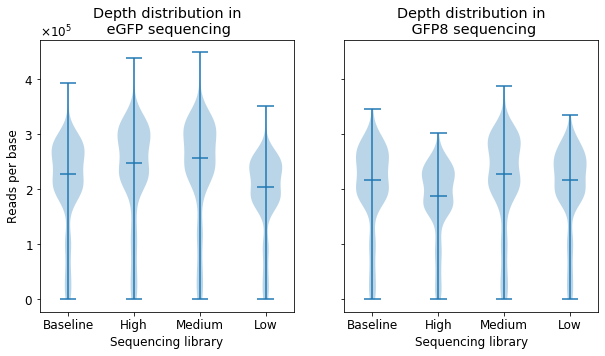

In [126]:
plt.rcParams.update({'font.size': 12})

fig1, (ax1, ax2)  = plt.subplots(1, 2, sharey=True, figsize=(10,5))

ax1.set_title('Depth distribution in\n eGFP sequencing')
ax1.violinplot(dataset = [depth_e['N'], depth_e['H'], depth_e['M'], depth_e['L']], showmedians=True)

ax2.set_title('Depth distribution in\n GFP8 sequencing')
ax2.violinplot(dataset = [depth_8['N'], depth_8['H'], depth_8['M'], depth_8['L']], showmedians=True)

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_xticklabels(['','Baseline', 'High', 'Medium', 'Low'])
    ax.set_xlabel('Sequencing library')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,1), useMathText=True)

ax1.set_ylabel('Reads per base')

plt.show()

**Figure A**: Violin plot of sequencing depth per base distribution in GFP sequencing. The minimum, median and maximum depth for each sequencing fraction are shown with horizontal lines. All libraries show a tail of low coverage, which originates from positions at the beginning and end of each gene.

In [144]:
# find positions where depth > 150,000
print('eGFP > 150,000: ', depth_e[depth_e.L >= 150000].Position.min(), depth_e[depth_e.L >= 150000].Position.max())
print('GFP8 > 150,000: ', depth_8[depth_8.H >= 150000].Position.min(), depth_8[depth_8.H >= 150000].Position.max())

eGFP > 150,000:  96 685
GFP8 > 150,000:  97 667


In both eGFP and GFP8 positions 96 - 691 inclusive have 150,000 reads per base or more.

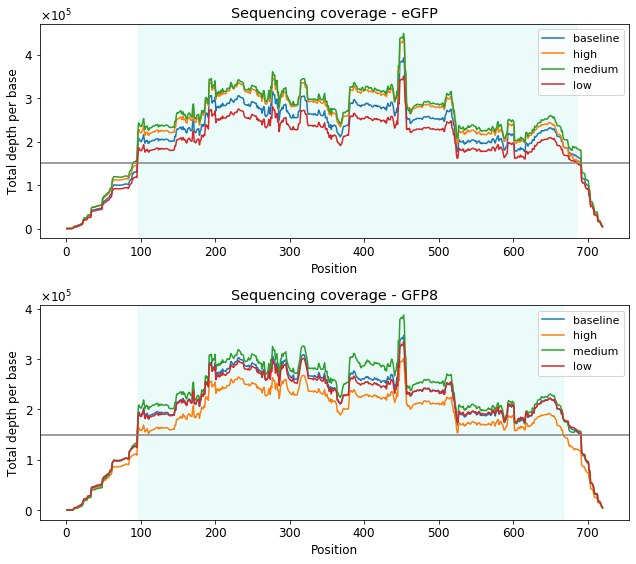

In [146]:
sns.color_palette("colorblind")


fig1, (ax1, ax2)  = plt.subplots(2, 1, figsize=(9,8))


for frac, label in {'N':'baseline', 'H':'high', 'M':'medium', 'L':'low'}.items():
    ax1.plot(depth_e.Position, depth_e[frac], label=label)
    ax2.plot(depth_8.Position, depth_8[frac], label=label)

# ax1.plot(depth_e.Position, depth_e[['N', 'H', 'M', 'L']], label=['a','b','c','c'])
# ax2.plot(depth_8.Position, depth_8[['N', 'H', 'M', 'L']])

ax1.set_title('Sequencing coverage - eGFP')
ax2.set_title('Sequencing coverage - GFP8')

ax1.axvspan(96, 685, alpha=0.1, color='turquoise')
ax2.axvspan(96, 667, alpha=0.1, color='turquoise')

for ax in (ax1, ax2):
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,1), useMathText=True)
    ax.legend(loc=1, fontsize=11)
    ax.axhline(y=150000, color='gray')
    ax.set_xlabel('Position')
    ax.set_ylabel('Total depth per base')

plt.tight_layout()

plt.show()

**Figure B**: We see the sequencing depth is similar across fractions in the core part of the gene, but drops of at the ends of the fragment. While there is some variation between background and between fractions, the overall trend is the same. The horizontal line shows a depth of >150,000 reads per base and the shaded area shows the part of the gene where depth is at or above this depth in the fraction with lowest coverate (low activity for eGFP and high for GFP8).

#### How many variants do we see?


Load results, which are in the form of a nested dictionary. The levels are:
- results (top level)
- protein background: 'eGFP' or 'GFP8'
- FACS fractions: 'H', 'L', 'MM', 'baseline'
- protein mutations in tuple format: eg. ((204, 's', 'L'), (222, 's', 'G')) or ((130,'d'),)
- data for each protein mutation:
    - 'total' : total number of reads supporting this protein mutation. This aggregates data from distinct DNA mutations that are synonymous in their effect on protein sequence, including likely sequencing errors.
    - 'depth' : average sequencing depth over this mutation
    - 'dna' : dictionary listing counts for each DNA mutation, ie. {(DNA tuple) : integer }
    - 'dna_hgvs' : a dictionary listing counts for each DNA mutation
        - The key for each distinct DNA mutation is the HGVS-like standard for describing DNA variation
        - Associated with each key is the count of reads that contain this DNA mutation
        
To access information for particular protein mutation:

results['eGFP']['baseline'][protein_tuple]

In [150]:
with open('gfp_with_hgvs_20180827.p', 'rb') as f:
    results = pickle.load(f)

results['eGFP'].keys()

dict_keys(['baseline', 'L', 'H', 'MM'])

At this stage, we are interested in the pre-sorting situation. Hence, this is an extension of the analysis before to see the distributions in the 'baseline' fractions.

**Table E**: The number of all variants observed at least 1× in the unsorted libraries, combined. We see the numbers of detected deletions are  one the same order of magnitude to those in the 'ideal' case, indicating that these are variants in the library. However, the number of substitutions is much inflated: this category on DNA level contains the true substitutions, as well as all the sequencing errors. This is further supported by the large _number_ of detected 'sd' (substitution + deletion) libraries, far exceeding the number of detected deletions.

In [151]:
dna_count, dna_reads = get_dna_composition(results, 1)
protein_count, protein_reads = get_full_protein_composition(results, 1)
filt_prot_count, filt_prot_reads = get_filtered_protein_composition(results, 1)

# Choose which 
fractions_all = ['eGFP.baseline', 'eGFP.H', 'eGFP.MM', 'eGFP.L', 'GFP8.baseline', 'GFP8.H', 'GFP8.MM', 'GFP8.L']

df_dna_count = pd.DataFrame(dna_count, index=row_index_dna, columns=fractions_all)
df_dna_reads = pd.DataFrame(dna_reads, index=row_index_dna, columns=fractions_all)

In [37]:
df_dna_count[['eGFP.baseline', 'GFP8.baseline']]

,eGFP.baseline,GFP8.baseline
d3,443,434
d6,436,439
d9,394,399
f,4304,5687
s,17551,19861
sd,4388,3830
other,161,203


In [152]:
df_dna_reads[['eGFP.baseline', 'GFP8.baseline']]

,eGFP.baseline,GFP8.baseline
d3,40073,29830
d6,34508,19252
d9,34776,30195
f,23792,39243
s,107685,122277
sd,4800,4184
other,1289,1455


We see that the number of reads corresponding to 'sd' variants is an order of magnitude smaller than reads supporting true deletions, which is in line with the premise that those mutations are primarily sequencing errors.

<font color=blue>
    
**Possible space for improvement: break down the DNA classification to reads containing:**
    
- only a single nucleotide mutation (could be a true variant or sequencing error)
- double nucleotide mutations, eg nnAATnn > nnACAnn (generated by TriNEx)
- triple nucleotide mutations (genereted by TriNeEx)
- non-consecutive single nucleotide mutations (sequencing errors)

How to do this? If the classification function on DNA level reads as a substitution, extract the positions and check for conscutiveness. Make sure the NTN/NCN/NAN/NGN mutations are accepted, ie. a triplet exchange where the first and last positions change but the middle is accidentally the same.
<\font>

Divide this by the ideal distribution calculated before to see what % deletions and substitutions we are seeing. The substitution figure is less reliable.

**Table F**: Proportion of observed DNA mutations in unsorted libraries compared to ideal composition - ie. what % of positions do we access.

In [154]:
id_dna_count['eGFP.baseline'] = id_dna_count['eGFP.base_d369'] + id_dna_count['eGFP.base_s3']
id_dna_count['GFP8.baseline'] = id_dna_count['GFP8.base_d369'] + id_dna_count['GFP8.base_s3']

dna_base_compare = df_dna_count[['eGFP.baseline', 'GFP8.baseline']]
dna_base_compare.div(id_dna_count[['eGFP.baseline', 'GFP8.baseline']])

,eGFP.baseline,GFP8.baseline
d3,0.840607,0.818868
d6,0.872000,0.871032
d9,0.771037,0.777778
f,inf,inf
s,0.531382,0.601411
sd,inf,inf
other,inf,inf


#### Interpretation of starting DNA library composition with non-stringent filtering

We see 300-450 variants per starting. The GFP gene is ~720 bp long, depending on where one sets the end of the gene (HindIII restriction site, His tag, barcode etc.). The theoretical diversity of an InDel library depends on the starting sequence: we know from analysis of PTE data that for deletions, the maximum diversity is about 0.75 distinct deletions per bp of gene length.

expected max size = 0.75 × 720 = 540 variants

The sequencing coverage is very low in the first and last 50 bp of the sequenced fragments, which was a technical limitation of the restriction site positions. Accounting for that, the effective fragment length is ~620 bp and we should see ~465 variants per library for full coverage.

We see that the baseline libraries contain 400-440 variants, more for the smaller and less for the larger variants. Hence, the starting detection looks good.

There is a substantial number of substitutions (`s`), which are mostly WT reads with sequencing errors, and combinations of deletions + substitutions (`sd`), where a true deletion is accompanied by a sequencing error. There may be true variants hidden in these fractions. The total number of variants with sub substitutions is much larger than pure target variants: for a common variant, there is only one correct variant but many ways it can be accompanied by a  sequencing error. In this way sequencing errors inflate the number of variants, by creating lots of rare variants.

In [155]:
df_dna_reads[['eGFP.baseline', 'GFP8.baseline']]

,eGFP.baseline,GFP8.baseline
d3,40073,29830
d6,34508,19252
d9,34776,30195
f,23792,39243
s,107685,122277
sd,4800,4184
other,1289,1455


The previous intuition is confirmed here: deletions in each library, each background are supported by 20K-40K reads each. Pure substitutions are still abundant, becaue the analysis starts with selecting ALL reads that deviate from WT - ie. we capture the true variants as well as all the noise.


#### Increase filtering stringency to 10 to examine substitutions

Re-examine statistics tables with more stringent filtering, to only consider mutations that were observed 5 or more times on DNA level.

In [156]:
dna_count_r, dna_reads_r = get_dna_composition(results, 5)
df = pd.DataFrame(dna_count_r, index=row_index_dna, columns=fractions_all)
df[['eGFP.baseline', 'GFP8.baseline']].div(df_dna_count[['eGFP.baseline', 'GFP8.baseline']])

,eGFP.baseline,GFP8.baseline
d3,0.830700,0.811060
d6,0.855505,0.790433
d9,0.829949,0.796992
f,0.223745,0.257078
s,0.285169,0.269221
sd,0.002963,0.003133
other,0.130435,0.133005


In [158]:
df = pd.DataFrame(dna_reads_r, index=row_index_dna, columns=fractions_all)
df[['eGFP.baseline', 'GFP8.baseline']].div(df_dna_reads[['eGFP.baseline', 'GFP8.baseline']])

,eGFP.baseline,GFP8.baseline
d3,0.996157,0.994335
d6,0.996146,0.988313
d9,0.996003,0.993973
f,0.783246,0.835665
s,0.812852,0.811469
sd,0.025417,0.022706
other,0.856478,0.834364


The above tables show that by filtering the composition analysis to only include the variants that were observed 5 or more times, we retain 80% of observed deletions, which still account for 99% reads with deletions. In substitutions, this filtering retains 28% of all observed substitutions, many of which are sequencing errors. The 'true' TriNEx variants are supported by 81% of all reads containing substitutions.

**Table G**: Number of distinct protein variants observed 5 or more times, before sorting the libraries.

In [159]:
filt_prot_count_r, filt_prot_reads_r = get_filtered_protein_composition(results, 5)
df = pd.DataFrame(filt_prot_count_r, index=row_index_prot, columns=fractions_all)
df[['eGFP.baseline', 'GFP8.baseline']]

,eGFP.baseline,GFP8.baseline
d,194,186
c-sd,113,110
c-dd,191,183
c-sdd,111,105
c-ddd,183,176
c-sddd,99,105
s,2118,2220
c-ss,820,925
*,181,184


<font color=blue>

**To Do: Histograms of observed substitutions vs read count**


#### Distribution of mutations across the target gene: transposon effects

All three deletion libraries are created starting with insertion of the TransDels transposon, which is an engineered form of the Mu transposon. The transposon duplicates a 5-nt target sequence, which in the case of -3 bp librarires is then *symmetrically* excised to leave behind the 1st and last nt of that sequence. By analysing the frequency of -3 bp insertions we can work backwards and directly observed the positio of insertion of the Mu transposon.

In [160]:
def find_transposon_histogram(all_references, background, baseline='baseline', transposon='d3'):
    """
    Find all mutation of a certain type and count where they are in DNA
    :return: dict
    """
    hist = defaultdict(int)
    # using a dictionary here allows us to get the positions and counts from the randomly disorganized counts
    # in the results dictionary
    for prot_mutation in all_references[background][baseline]:
        if prot_mutation is None:
            continue
        elif len(prot_mutation) <= 2:
            for dna_mutation, count in all_references[background][baseline][prot_mutation]['dna'].items():
                # here we are looking at dna mutations in the tuple format: (position, type, length)
                # for deletions, the position in the first bp of tuple is the FIRST position in 1-count (ie. biology standard)
                # where the nucleotide is deleted.
                # Example: HGVS 74_76del -> (74, d, 3)
                if classify_dna(dna_mutation) == transposon:
                    hist[int(dna_mutation[0][0])] += count
    
    # now convert this in an organised list
    gene_length = max(hist.keys()) + 1
    all_pos = list(range(720))
    d3_cnts = [hist[pos] for pos in all_pos] # 'hist' is a default dict: will return 0 for missing values
    
    
    return {'Position': all_pos, 'd3_count': d3_cnts}

histogram = find_transposon_histogram(results, 'eGFP', baseline='baseline', transposon='d3')
# here, the keys are positions

First, we convert the number of observations per positions to the aggregate

In [161]:
df_hist = pd.DataFrame.from_dict(histogram)
df_hist['d3_count'].describe()

count     720.000000
mean       55.656944
std       148.584870
min         0.000000
25%         0.000000
50%         5.000000
75%        44.000000
max      2105.000000
Name: d3_count, dtype: float64

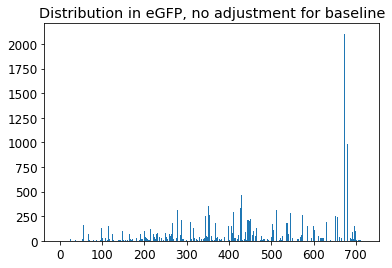

In [162]:
plt.bar(df_hist['Position'], df_hist['d3_count'], width=1)
plt.title('Distribution in eGFP, no adjustment for baseline')
plt.show()

# make this a prettier histogram with a split axis that lets you see all positions.

<font color=blue> 
**Make histogram prettier. Include baseline adjustment.**

#### How many deletions per position are detected?

In [163]:
def insertion_frequencies(results, background):

    ins_freq = {deletion: defaultdict(int) for deletion in ['d3','d6','d9']}  # the starting data is aggregated in the 'baseline' fraction

    for prot_mutation, data in results[background]['baseline'].items():  # this will go through all protein mutations
        for dna_mutation, c in data['dna'].items():
            # sometimes a mutations will have a sequencing error / silent substitution elsewhere, which biases the count
            dna_mut_type = classify_dna(dna_mutation)
            if dna_mut_type in ['d3', 'd6', 'd9']:
                prot_mut_type = classify_protein(prot_mutation)
                if prot_mut_type in translate_variant_type(dna_mut_type):
                    ins_freq[dna_mut_type][int(dna_mutation[0][0])] += 1
    
    position = list(range(720))
    d3_cnts = [ins_freq['d3'][pos] for pos in position]
    d6_cnts = [ins_freq['d6'][pos] for pos in position]
    d9_cnts = [ins_freq['d9'][pos] for pos in position]
    
    return {'Position': position, 'd3': d3_cnts, 'd6': d6_cnts, 'd9': d9_cnts}
    
ins_freq_e = insertion_frequencies(results, 'eGFP')
ins_freq_8 = insertion_frequencies(results, 'GFP8')

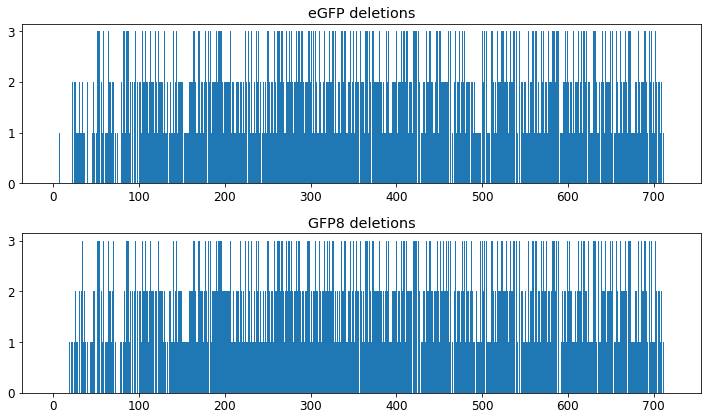

In [166]:
df_e = pd.DataFrame.from_dict(ins_freq_e)
df_8 = pd.DataFrame.from_dict(ins_freq_8)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

for df in [df_e, df_8]:
    df['dels'] = df['d3'] + df['d6'] + df['d9']
    
ax1.bar(df_e['Position'], df_e['dels'], width=1)
ax2.bar(df_8['Position'], df_8['dels'], width=1)

ax1.set_title('eGFP deletions')
ax2.set_title('GFP8 deletions')

plt.tight_layout()
plt.show()
# df_ins_freq.to_csv('Fig3BC_all_ref.csv')

In [175]:
dels_agg_e = df_e['dels'].value_counts()
dels_agg_8 = df_8['dels'].value_counts()
print('eGFP', dels_agg_e/720*100, 'GFP8',dels_agg_8/720*100, sep='\n')

eGFP
2    37.777778
1    25.833333
3    25.138889
0    11.250000
Name: dels, dtype: float64
GFP8
2    37.777778
1    26.111111
3    25.000000
0    11.111111
Name: dels, dtype: float64


We see that 25% of positions have all three positions and 11% are entirely unobserved. This must be adjusted by taking into account the baseline.

<font color=blue> 
**Build similar plot for substitutions**

### Look for the most common variants in the High dataset

In [23]:
# Make a Counter dictionary just with dna_hgvs mutations and counts
# Here, associate just the HGVS DNA variant description and the count

gfp_dna = {'eGFP': {}, 'GFP8': {}}
for bg in results.keys():
    for fraction in results[bg].keys():
        gfp_dna[bg][fraction] = {}
        for pm, pdata in results[bg][fraction].items():  # pm - protein mutation
            for dna, reads in pdata['dna_hgvs'].items():
                gfp_dna[bg][fraction][dna] = reads
        del gfp_dna[bg][fraction][None]
        del gfp_dna[bg][fraction][str(bg) + ':c.[]']

# once we're done extraction all information, convert to Counter

gfp_cnt = {'eGFP': {}, 'GFP8': {}}
for bg in gfp_cnt.keys():
    for fraction in results[bg].keys():
        gfp_cnt[bg][fraction] = Counter(gfp_dna[bg][fraction])


Working with a simpler `Counter` for DNA/read statistics is useful for converting to a dataframe, but the linkage between the DNA variant and the effect when translated to protein is lost. Make up for this by making a separate "translation" dictionary.

In [24]:
# Helper dictionary: DNA_hgvs to protein

gfp_translate = {'eGFP': {}, 'GFP8': {}}

for bg in results.keys():
    for fraction in results[bg].keys():
        gfp_dna[bg][fraction] = {}
        for pm, pdata in results[bg][fraction].items():  # pm - protein mutation
            for dna in pdata['dna_hgvs'].keys():
                try:
                    gfp_translate[bg][dna]
                except KeyError:
                    gfp_translate[bg][dna] = pm

In [25]:
# Find the top 15 H mutations

def top_variant_distribution(gfp_cnt, bg, fraction, filename):

    top = gfp_cnt[bg][fraction].most_common(100)
    with open(filename, 'w') as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerow(['DNA_hgvs', 'Protein', 'Baseline', 'High', 'Medium', 'Low'])
        for pair in top:
            dna_hgvs = pair[0]
            try:
                protein = gfp_translate[bg][dna_hgvs]
            except KeyError:
                print(dna_hgvs)
                raise
            csv_writer.writerow([dna_hgvs, protein, gfp_cnt[bg]['baseline'][dna_hgvs], 
                                 gfp_cnt[bg]['H'][dna_hgvs], gfp_cnt[bg]['MM'][dna_hgvs], gfp_cnt[bg]['L'][dna_hgvs]] )

top_variant_distribution(gfp_cnt, 'eGFP', 'H', 'Top_variants_eGFP_H.csv')
top_variant_distribution(gfp_cnt, 'GFP8', 'H', 'Top_variants_GFP8_H.csv')

df_top = pd.read_csv('Top_variants_GFP8_H.csv')
df_top = pd.read_csv('Top_variants_eGFP_H.csv')
df_top.head(15)

,DNA_hgvs,Protein,Baseline,High,Medium,Low
0,eGFP:c.674_676del,"((226, 'd'),)",2105,9468,340,13
1,eGFP:c.458_463del,"((153, 's', 'N'), (154, 'd'), (155, 'd'))",1247,4938,5409,9
2,eGFP:c.681_686del,"((228, 'd'), (229, 'd'))",708,4120,275,0
3,eGFP:c.681_683del,"((228, 'd'),)",988,3376,852,7
4,eGFP:c.678_686del,"((227, 'd'), (228, 'd'), (229, 'd'))",276,3050,1,3
5,eGFP:c.692_700del,"((232, 'd'), (233, 'd'), (234, 'd'))",169,1978,1,0
6,eGFP:c.678_683del,"((227, 'd'), (228, 'd'))",178,1140,625,1
7,eGFP:c.462_467del,"((155, 'd'), (156, 'd'))",171,1095,702,2
8,eGFP:c.574_576del,"((192, 'd'),)",216,1014,173,0
9,eGFP:c.690_692del,"((231, 'd'),)",184,986,73,0


In [26]:
gfp_translate['eGFP']['eGFP:c.39A>T']

()